#Análisis Comparativo de Modelos RNN y LSTM para Clasificación de Emociones en Texto

##Objetivo General:

Implementar y comparar el desempeño de una red neuronal recurrente tradicional (RNN) y una red neuronal con memoria a largo plazo (LSTM) para la tarea de clasificación de emociones a partir de frases escritas en inglés, utilizando un conjunto de datos estándar disponible en Hugging Face.

##Metodología

El presente trabajo se desarrolló siguiendo un enfoque experimental de comparación de modelos secuenciales. A continuación se detallan los pasos seguidos:

1. **Selección del conjunto de datos:**  
Se utilizó el dataset de emociones disponible en Hugging Face, compuesto por frases en inglés etiquetadas en seis emociones principales (`joy`, `anger`, `sadness`, `fear`, `love`, `surprise`).

2. **Preprocesamiento de los datos:**  
- Se aplicó tokenización simple a las frases, separando palabras por espacios.  
- Se construyó un vocabulario utilizando las palabras más frecuentes, agregando tokens especiales `<pad>` y `<unk>`.  
- Se codificaron las frases en secuencias de índices numéricos.  
- Se aplicó padding dinámico para igualar las longitudes de las secuencias dentro de cada batch.

3. **Definición de modelos secuenciales:**  
- Se implementó un modelo RNN tradicional utilizando PyTorch, compuesto por una capa de embedding, una capa `nn.RNN` y una capa lineal final.  
- Se implementó un modelo LSTM avanzado compuesto por una capa de embedding, una capa `nn.LSTM` con dos capas ocultas, y una capa lineal de clasificación.

4. **Entrenamiento de los modelos:**  
- El modelo RNN fue entrenado durante 20 épocas, dado su rápido estancamiento en el aprendizaje.  
- El modelo LSTM fue entrenado durante 50 épocas, permitiendo explotar su capacidad de modelar dependencias de largo plazo.

5. **Evaluación y comparación:**  
- Se evaluaron ambos modelos utilizando precisión (`accuracy`), matriz de confusión y F1-score.  
- Se realizaron gráficas de la evolución de la pérdida y la precisión para ambos modelos.  
- Se realizó una comparación técnica y conceptual de los resultados obtenidos.

6. **Reflexión crítica:**  
Se discutieron las limitaciones observadas en el desempeño del modelo RNN y las ventajas evidenciadas en el modelo LSTM.


## Implementación de la Solución


**Carga del Dataset**

Se utilizó el conjunto de datos **Emotion** disponible en Hugging Face, el cual contiene frases escritas en inglés etiquetadas en seis emociones principales: alegría (`joy`), enojo (`anger`), tristeza (`sadness`), miedo (`fear`), amor (`love`) y sorpresa (`surprise`).

Para ello se empleó la librería `datasets`, que permite descargar y manipular de forma sencilla conjuntos de datos populares en tareas de procesamiento de lenguaje natural (NLP).


In [1]:
!pip install datasets

from datasets import load_dataset

# Cargar el dataset de emociones
dataset = load_dataset('emotion')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
!pip install torch==2.0.1 torchtext==0.15.2



**Preprocesamiento de los Datos: Tokenización y Creación del Vocabulario**

Para preparar los datos textuales para los modelos secuenciales, se realizó un proceso de tokenización y creación del vocabulario:

- **Tokenización:** Se definió una función básica que convierte las frases en minúsculas y las separa en palabras individuales utilizando espacios.
- **Creación del Vocabulario:** A partir de los datos tokenizados del conjunto de entrenamiento, se construyó un vocabulario que asigna un índice numérico único a cada palabra.
- **Incorporación de tokens especiales:** Se añadieron los tokens `<pad>` (para rellenar secuencias de diferente longitud) y `<unk>` (para representar palabras desconocidas).
- **Configuración del manejo de palabras fuera del vocabulario:** Se estableció el token `<unk>` como índice predeterminado para cualquier palabra que no haya sido vista durante el entrenamiento.

Este preprocesamiento garantiza que los datos de entrada estén listos para ser procesados por las redes neuronales, con una representación numérica eficiente y manejando adecuadamente palabras nuevas o frases de diferente longitud.




```
vocab = build_vocab_from_iterator(yield_tokens(dataset['train']), specials=['<pad>', '<unk>'])

```
Se recorre la frase tokenizada, y se crea un diccionario con cada palabra y un número único, además agrega los tokens especiales


In [3]:
from collections import Counter
import torch
from torchtext.vocab import build_vocab_from_iterator

# Tokenización básica
def tokenize(text):
    return text.lower().split()

# Construir vocabulario a partir de los datos
def yield_tokens(data_iter):
    for example in data_iter:
        yield tokenize(example['text'])

# Crear vocabulario
special_tokens = ['<pad>', '<unk>']
vocab = build_vocab_from_iterator(yield_tokens(dataset['train']), specials=special_tokens)

# Configurar que use <unk> para palabras desconocidas
vocab.set_default_index(vocab['<unk>'])

print(f"Vocabulario creado con {len(vocab)} palabras.")



Vocabulario creado con 15214 palabras.


**Codificación de Frases, Creación de Datasets y Dataloaders**

En esta sección se procedió a transformar las frases de texto en secuencias de índices numéricos, y a preparar los conjuntos de datos para su uso en el entrenamiento de los modelos.

- **Codificación de frases:**  
Se definió una función `encode` que toma una frase tokenizada y reemplaza cada palabra por su índice correspondiente en el vocabulario previamente construido.

- **Creación de un Dataset personalizado:**  
Se implementó la clase `EmotionDataset`, la cual facilita la organización de los datos de entrada (`text`) y sus respectivas etiquetas (`label`) en un formato compatible con PyTorch.

- **Aplicación de padding dinámico:**  
Se implementó la función `collate_batch`, que permite rellenar automáticamente las secuencias más cortas dentro de cada batch con el token `<pad>`, asegurando que todas las secuencias tengan la misma longitud para el procesamiento por lotes.

- **Creación de DataLoaders:**  
Se generaron tres conjuntos de datos (`train`, `validation` y `test`) y sus respectivos `DataLoaders`, que permiten el entrenamiento, validación y prueba de los modelos de manera eficiente. El conjunto de entrenamiento fue configurado con `shuffle=True` para promover un aprendizaje más robusto.

Este preprocesamiento garantiza que los datos textuales sean adecuadamente preparados para su procesamiento secuencial en redes neuronales.


In [4]:
# Función para convertir texto a secuencia de índices
def encode(text):
    tokens = tokenize(text)
    return [vocab[token] for token in tokens]


In [5]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

# Dataset personalizado
class EmotionDataset(Dataset):
    def __init__(self, split):
        self.texts = dataset[split]['text']
        self.labels = dataset[split]['label']

    def __getitem__(self, idx):
        text = encode(self.texts[idx])
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

# Función para aplicar padding dinámico a los batches
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts, labels

# Crear datasets y dataloaders
train_dataset = EmotionDataset('train')
val_dataset = EmotionDataset('validation')
test_dataset = EmotionDataset('test')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

print("DataLoaders creados correctamente.")


DataLoaders creados correctamente.


###RNN

**Definición del Modelo RNN Tradicional**

Se definió la arquitectura de un modelo de red neuronal recurrente (RNN) básico utilizando PyTorch, compuesto por los siguientes elementos:

- **Capa de embeddings:**  
  Se implementó una capa de embeddings (`nn.Embedding`) que transforma cada índice numérico de palabra en un vector denso de tamaño fijo (`embedding_dim`). Esta es la etapa donde se construye el **espacio semántico**, permitiendo representar palabras de manera más rica y continua.

- **Capa RNN:**  
  Se utilizó una capa `nn.RNN` tradicional que procesa las secuencias de vectores de embeddings palabra por palabra, actualizando una memoria interna que captura información del contexto secuencial.

- **Capa lineal de clasificación:**  
  La última memoria oculta generada por la RNN (`hidden`) se procesa a través de una capa lineal (`nn.Linear`) que transforma la representación en un conjunto de logits, uno por cada clase de emoción.

El modelo recibe como entrada una frase codificada, la transforma en un espacio semántico a través de embeddings, procesa la secuencia con la RNN, y finalmente predice la emoción correspondiente mediante la capa de clasificación.


In [6]:
import torch.nn as nn

class BasicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # RNN tradicional (una sola capa, no LSTM ni GRU)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)

        # Capa lineal final
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]
        output, hidden = self.rnn(embedded)  # output: todos los pasos, hidden: solo el último
        final_hidden = hidden.squeeze(0)  # Quitamos la dimensión extra de la RNN
        return self.fc(final_hidden)  # [batch, output_dim]


**Configuración del Dispositivo, Instanciación del Modelo, Función de Pérdida y Optimizador**

En esta sección se realizó la preparación final para el entrenamiento del modelo RNN:

- **Selección del dispositivo:**  
Se configuró el dispositivo de cómputo (`cpu` o `cuda` si hay GPU disponible) para acelerar el entrenamiento en caso de contar con una GPU.

- **Definición de hiperparámetros:**  
Se especificaron los principales hiperparámetros del modelo:
  - `vocab_size`: tamaño del vocabulario (número de palabras únicas).
  - `embedding_dim`: tamaño de los vectores de embedding (100 dimensiones).
  - `hidden_dim`: tamaño de la memoria oculta de la RNN (128 unidades).
  - `output_dim`: número de clases (6 emociones).
  - `pad_idx`: índice reservado para el token `<pad>`.

- **Instanciación del modelo RNN:**  
Se creó una instancia del modelo `BasicRNN`, moviéndola al dispositivo seleccionado (GPU o CPU).

- **Definición de la función de pérdida:**  
Se utilizó `CrossEntropyLoss`, adecuada para problemas de clasificación multiclase, la cual combina la aplicación de softmax a la salida del modelo y el cálculo de la pérdida de entropía cruzada.

- **Definición del optimizador:**  
Se empleó el optimizador `Adam`, que ajusta dinámicamente las tasas de aprendizaje de los parámetros del modelo para facilitar una convergencia más eficiente.

Con esta configuración, el modelo quedó completamente listo para iniciar el proceso de entrenamiento.


In [7]:
# Configuraciones principales
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)          # Número de palabras en el vocabulario
embedding_dim = 100              # Tamaño de los vectores de embedding
hidden_dim = 128                 # Número de neuronas ocultas en la RNN
output_dim = 6                   # Número de clases (emociones)
pad_idx = vocab['<pad>']          # Índice del token de padding

# Instanciar el modelo
model_rnn = BasicRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)
model_rnn = model_rnn.to(device)

# Definir función de pérdida
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Definir optimizador
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

print("Modelo, criterio y optimizador creados.")


Modelo, criterio y optimizador creados.


**Definición de las Funciones de Entrenamiento y Evaluación**

En esta sección se definieron las funciones necesarias para entrenar y evaluar el modelo RNN:

- **Función `train(model, loader)`:**  
  - Establece el modelo en modo entrenamiento (`model.train()`).
  - Itera sobre los lotes del `DataLoader`.
  - Para cada batch:
    - Mueve los datos al dispositivo adecuado (CPU o GPU).
    - Realiza la predicción (`model(X_batch)`).
    - Calcula la pérdida (`CrossEntropyLoss`).
    - Retropropaga el error (`loss.backward()`).
    - Actualiza los pesos (`optimizer.step()`).
  - Retorna la pérdida promedio al final de la época.

- **Función `evaluate(model, loader)`:**  
  - Establece el modelo en modo evaluación (`model.eval()`), desactivando operaciones de autograd.
  - Itera sobre los lotes del `DataLoader` sin actualizar los pesos.
  - Para cada batch:
    - Realiza la predicción.
    - Calcula cuántas predicciones fueron correctas comparándolas con las etiquetas reales.
  - Retorna la precisión (`accuracy`) como el porcentaje de predicciones correctas.

Estas funciones permiten gestionar de manera modular el entrenamiento y la evaluación del modelo a lo largo de las diferentes épocas.


In [8]:
# Función de entrenamiento
def train(model, loader):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predicted = torch.argmax(predictions, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total


**Bucle de Entrenamiento del Modelo RNN**

Se implementó el bucle de entrenamiento para el modelo RNN:

- Se definió el número de épocas de entrenamiento (`epochs = 20`).
- En cada época:
  - Se entrenó el modelo utilizando la función `train()`.
  - Se evaluó el modelo sobre el conjunto de validación con `evaluate()`.
  - Se registraron las pérdidas de entrenamiento (`train_losses`) y las precisiones de validación (`val_accuracies`) para su posterior análisis y visualización.

Este bucle permitió monitorizar el desempeño del modelo a lo largo del entrenamiento.


In [9]:
# Bucle de entrenamiento
epochs = 20

train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train(model_rnn, train_loader)
    val_acc = evaluate(model_rnn, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Época {epoch+1}: pérdida = {train_loss:.4f} | precisión val. = {val_acc:.4f}")


Época 1: pérdida = 1.5874 | precisión val. = 0.3485
Época 2: pérdida = 1.5770 | precisión val. = 0.2750
Época 3: pérdida = 1.5755 | precisión val. = 0.3485
Época 4: pérdida = 1.5726 | precisión val. = 0.3495
Época 5: pérdida = 1.5715 | precisión val. = 0.3460
Época 6: pérdida = 1.5704 | precisión val. = 0.2730
Época 7: pérdida = 1.5710 | precisión val. = 0.3490
Época 8: pérdida = 1.5681 | precisión val. = 0.3450
Época 9: pérdida = 1.5675 | precisión val. = 0.3485
Época 10: pérdida = 1.5681 | precisión val. = 0.3370
Época 11: pérdida = 1.5672 | precisión val. = 0.3470
Época 12: pérdida = 1.5667 | precisión val. = 0.3485
Época 13: pérdida = 1.5647 | precisión val. = 0.3475
Época 14: pérdida = 1.5632 | precisión val. = 0.3440
Época 15: pérdida = 1.5644 | precisión val. = 0.3460
Época 16: pérdida = 1.5628 | precisión val. = 0.3395
Época 17: pérdida = 1.5773 | precisión val. = 0.3430
Época 18: pérdida = 1.5664 | precisión val. = 0.3480
Época 19: pérdida = 1.5655 | precisión val. = 0.3455
Ép

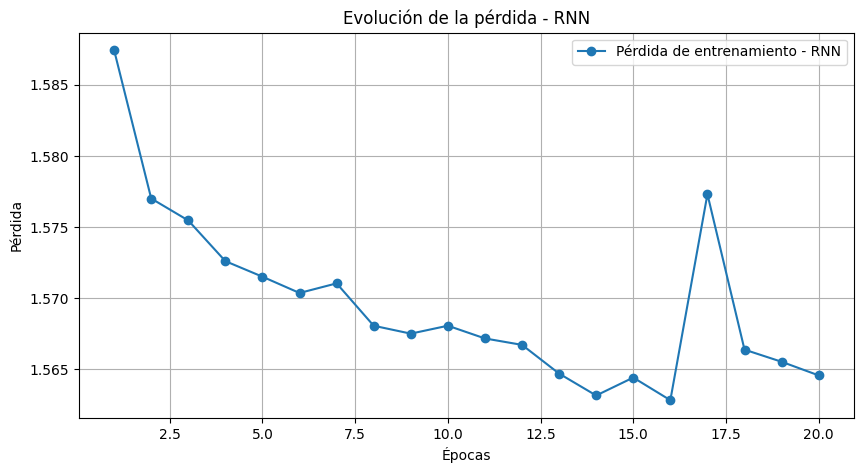

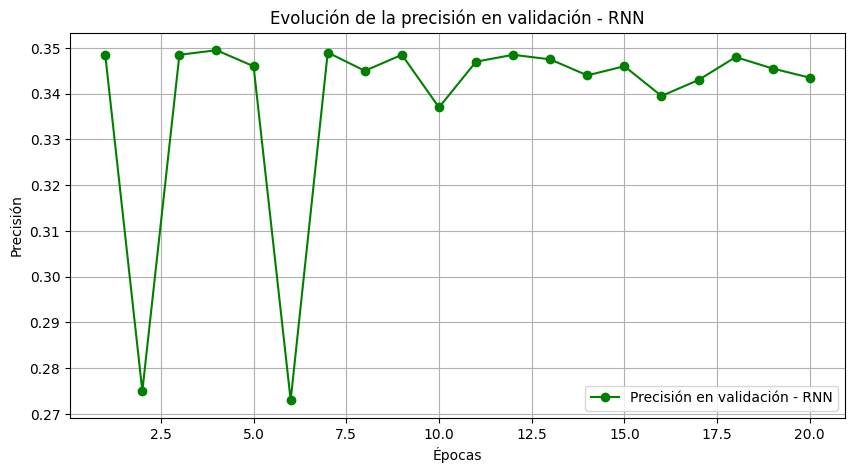

In [10]:
import matplotlib.pyplot as plt

# Gráfica de la pérdida para RNN
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Pérdida de entrenamiento - RNN')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida - RNN')
plt.grid()
plt.legend()
plt.show()

# Gráfica de la precisión en validación para RNN
plt.figure(figsize=(10,5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', color='green', label='Precisión en validación - RNN')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión en validación - RNN')
plt.grid()
plt.legend()
plt.show()


El modelo RNN tradicional mostró una limitada capacidad de aprendizaje en la tarea de clasificación emocional. Aunque logró mantener una precisión estable cercana al 34%-35%, no pudo mejorar significativamente con el tiempo, ni captar las dependencias complejas del lenguaje. Esto evidencia que su arquitectura, basada solo en hidden states simples sin control explícito de memoria, resulta insuficiente para problemas de procesamiento de lenguaje natural que requieren comprensión de contexto más amplio.

###LSTM


**Definición del Modelo LSTM Avanzado**

Se definió la arquitectura de un modelo basado en redes neuronales con memoria a largo plazo (LSTM) utilizando PyTorch, con la siguiente estructura:

- **Capa de embeddings:**  
  Se implementó una capa `nn.Embedding` que convierte los índices de palabras en vectores densos de tamaño `embedding_dim`. Esta capa constituye el espacio semántico de representación de las palabras.

- **Capa LSTM:**  
  En lugar de una RNN tradicional, se utilizó una `nn.LSTM` de dos capas ocultas (`num_layers=2`), lo cual permite capturar relaciones de largo plazo en las secuencias de texto.  
  Se añadió un `dropout` del 30% para prevenir el sobreajuste entre las capas.

- **Capa lineal de clasificación:**  
  Se tomó el `hidden` de la última capa y se procesó a través de una capa lineal (`nn.Linear`) para generar un vector de logits, uno por cada clase de emoción.

- **Función forward:**  
  Durante la propagación hacia adelante, el modelo:
  1. Convierte las frases codificadas en embeddings.
  2. Procesa las secuencias de embeddings mediante la LSTM.
  3. Toma la memoria final (`hidden[-1,:,:]`) para representar la frase.
  4. Pasa esta representación por la capa lineal para obtener la predicción final.

Esta arquitectura es más robusta que el RNN tradicional, permitiendo capturar dependencias de mayor longitud en los datos textuales.


**Funcionamiento Interno del LSTM: Redes dentro de Redes**

El LSTM puede entenderse como una red neuronal que contiene **múltiples mini-redes internas**, encargadas de controlar el flujo de la información a través del tiempo.

En cada paso temporal, el LSTM utiliza tres mecanismos principales, denominados **gates** o **puertas**, cada uno de ellos implementado mediante una pequeña red neuronal:

- **Forget Gate (Puerta de Olvido):**  
  Decide cuánta información de la memoria anterior debe ser olvidada.  
  Se implementa como una red lineal seguida de una función sigmoide (`σ`), que genera valores entre 0 y 1, indicando qué partes de la memoria deben ser conservadas o eliminadas.

- **Input Gate (Puerta de Entrada):**  
  Decide cuánta información nueva debe ser incorporada en la memoria.  
  Utiliza otra red lineal + sigmoide para determinar qué nuevas características deben ser añadidas.

- **Output Gate (Puerta de Salida):**  
  Decide qué parte de la memoria actual se debe exponer como la salida del paso de tiempo actual.  
  También implementada mediante una red lineal + sigmoide.

Cada una de estas puertas **aprende sus propios parámetros** durante el proceso de entrenamiento, mediante retropropagación, igual que una red neuronal clásica.

Así, **el LSTM es efectivamente una red neuronal grande que contiene varias mini-redes neuronales internas** especializadas en aprender a **controlar, mantener y manipular la memoria** de manera óptima a lo largo de secuencias largas.

Este mecanismo permite que los LSTM manejen eficientemente dependencias de largo plazo en el tiempo, a diferencia de las RNN tradicionales.


In [20]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # LSTM en lugar de RNN
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)

        # Capa lineal final
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]
        output, (hidden, cell) = self.lstm(embedded)  # hidden: [num_layers, batch, hidden_dim]
        final_hidden = hidden[-1,:,:]  # Tomamos el hidden de la última capa
        return self.fc(final_hidden)  # [batch, output_dim]


In [21]:
# Instanciar el modelo LSTM
model_lstm = LSTMModel(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=6,
    pad_idx=vocab['<pad>']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm = model_lstm.to(device)

# Función de pérdida
criterion_lstm = nn.CrossEntropyLoss()
criterion_lstm = criterion_lstm.to(device)

# Optimizador
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

print("Modelo LSTM, criterio y optimizador creados.")


Modelo LSTM, criterio y optimizador creados.


**Definición de las Funciones de Entrenamiento y Evaluación para el Modelo LSTM**

En esta sección se definieron las funciones específicas para entrenar y evaluar el modelo LSTM:

- **Función `train_lstm(model, loader)`:**  
  - Establece el modelo en modo entrenamiento (`model.train()`).
  - Itera sobre los lotes de datos del `DataLoader`.
  - Para cada batch:
    - Mueve los datos al dispositivo adecuado (CPU o GPU).
    - Realiza la predicción del modelo (`model(X_batch)`).
    - Calcula la pérdida utilizando `criterion_lstm` (CrossEntropyLoss).
    - Retropropaga el error (`loss.backward()`).
    - Actualiza los pesos del modelo (`optimizer_lstm.step()`).
  - Acumula la pérdida total para calcular la pérdida promedio de toda la época.

- **Función `evaluate_lstm(model, loader)`:**  
  - Establece el modelo en modo evaluación (`model.eval()`), desactivando el cálculo de gradientes para ahorrar memoria y acelerar el proceso.
  - Itera sobre los lotes del `DataLoader`.
  - Para cada batch:
    - Predice las clases.
    - Calcula el número de predicciones correctas comparándolas con las etiquetas reales.
  - Retorna la precisión (`accuracy`) como porcentaje de aciertos.

Estas funciones son esenciales para gestionar de manera ordenada el entrenamiento y la evaluación del modelo LSTM a lo largo de las diferentes épocas.


In [22]:
# Función de entrenamiento para el LSTM
def train_lstm(model, loader):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_lstm.zero_grad()
        predictions = model(X_batch)
        loss = criterion_lstm(predictions, y_batch)
        loss.backward()
        optimizer_lstm.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación para el LSTM
def evaluate_lstm(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predicted = torch.argmax(predictions, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total


In [23]:
# Bucle de entrenamiento para el LSTM
epochs = 50

train_losses_lstm = []
val_accuracies_lstm = []

for epoch in range(epochs):
    train_loss = train_lstm(model_lstm, train_loader)
    val_acc = evaluate_lstm(model_lstm, val_loader)

    train_losses_lstm.append(train_loss)
    val_accuracies_lstm.append(val_acc)

    print(f"Época {epoch+1}: pérdida = {train_loss:.4f} | precisión val. = {val_acc:.4f}")


Época 1: pérdida = 1.5867 | precisión val. = 0.3520
Época 2: pérdida = 1.5768 | precisión val. = 0.3520
Época 3: pérdida = 1.5747 | precisión val. = 0.3520
Época 4: pérdida = 1.5724 | precisión val. = 0.3525
Época 5: pérdida = 1.5679 | precisión val. = 0.3515
Época 6: pérdida = 1.5623 | precisión val. = 0.3520
Época 7: pérdida = 1.5571 | precisión val. = 0.3410
Época 8: pérdida = 1.5370 | precisión val. = 0.3490
Época 9: pérdida = 1.5205 | precisión val. = 0.3525
Época 10: pérdida = 1.5224 | precisión val. = 0.3565
Época 11: pérdida = 1.4936 | precisión val. = 0.3475
Época 12: pérdida = 1.4390 | precisión val. = 0.3845
Época 13: pérdida = 1.2548 | precisión val. = 0.4345
Época 14: pérdida = 1.0369 | precisión val. = 0.4840
Época 15: pérdida = 0.8510 | precisión val. = 0.5740
Época 16: pérdida = 0.7200 | precisión val. = 0.6715
Época 17: pérdida = 0.4799 | precisión val. = 0.8380
Época 18: pérdida = 0.2938 | precisión val. = 0.8735
Época 19: pérdida = 0.2116 | precisión val. = 0.8745
Ép

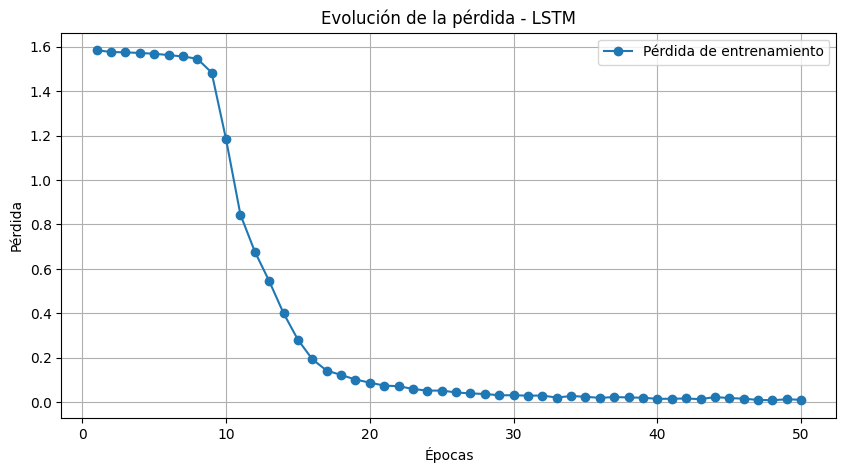

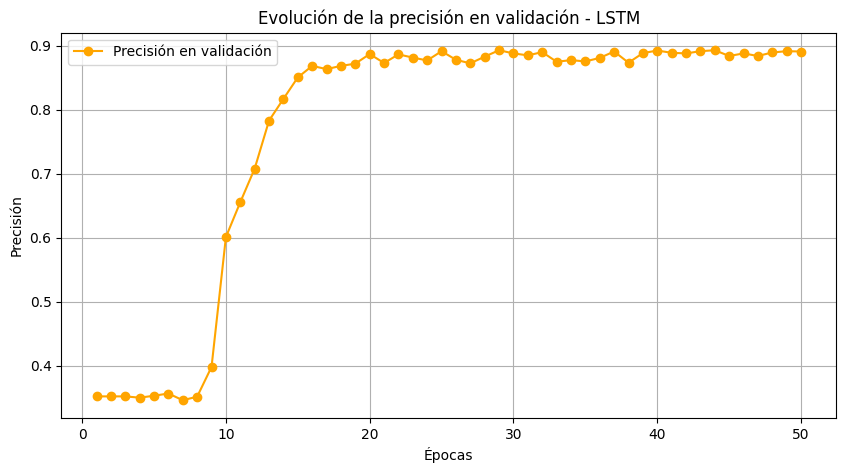

In [15]:
import matplotlib.pyplot as plt

# Gráfica de la pérdida
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses_lstm)+1), train_losses_lstm, marker='o', label='Pérdida de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida - LSTM')
plt.grid()
plt.legend()
plt.show()

# Gráfica de precisión en validación
plt.figure(figsize=(10,5))
plt.plot(range(1, len(val_accuracies_lstm)+1), val_accuracies_lstm, marker='o', color='orange', label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión en validación - LSTM')
plt.grid()
plt.legend()
plt.show()


El modelo LSTM mostró un aprendizaje progresivo altamente efectivo. Aunque inicialmente requirió varias épocas para ajustar sus pesos, logró capturar correctamente las relaciones de largo plazo en las secuencias textuales. Esto se reflejó en un aumento sustancial de precisión, alcanzando y manteniendo valores cercanos al 90% en validación, demostrando una clara ventaja estructural frente a la RNN tradicional para tareas de clasificación emocional.

###Predicción

In [16]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


In [17]:
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predicted = torch.argmax(predictions, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


In [18]:
!pip install numpy==1.24.3


RNN - Accuracy final: 0.3435
RNN - F1-score: 0.1962


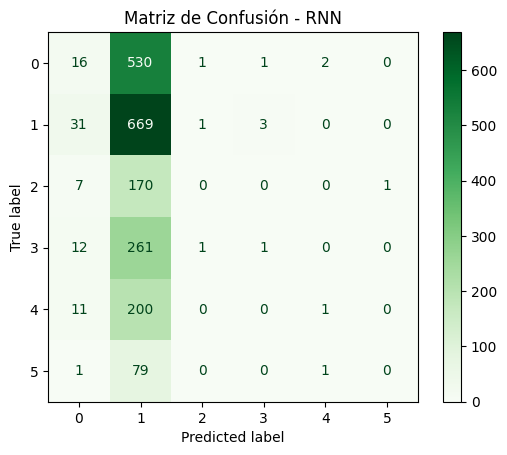

In [24]:
# Evaluar el RNN
preds_rnn, labels_rnn = get_predictions_and_labels(model_rnn, val_loader)

# Calcular Accuracy y F1-score
acc_rnn = np.mean(preds_rnn == labels_rnn)
f1_rnn = f1_score(labels_rnn, preds_rnn, average='weighted')

print(f"RNN - Accuracy final: {acc_rnn:.4f}")
print(f"RNN - F1-score: {f1_rnn:.4f}")

# Matriz de confusión
cm_rnn = confusion_matrix(labels_rnn, preds_rnn)
disp_rnn = ConfusionMatrixDisplay(confusion_matrix=cm_rnn)
disp_rnn.plot(cmap='Greens')
plt.title('Matriz de Confusión - RNN')
plt.show()


LSTM - Accuracy final: 0.9075
LSTM - F1-score: 0.9068


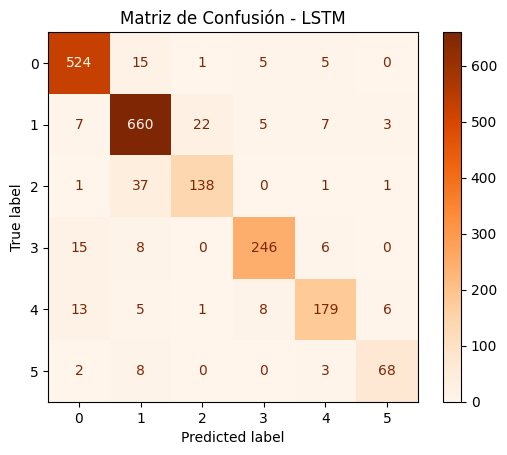

In [25]:
# Evaluar el LSTM
preds_lstm, labels_lstm = get_predictions_and_labels(model_lstm, val_loader)

# Calcular Accuracy y F1-score
acc_lstm = np.mean(preds_lstm == labels_lstm)
f1_lstm = f1_score(labels_lstm, preds_lstm, average='weighted')

print(f"LSTM - Accuracy final: {acc_lstm:.4f}")
print(f"LSTM - F1-score: {f1_lstm:.4f}")

# Matriz de confusión
cm_lstm = confusion_matrix(labels_lstm, preds_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm)
disp_lstm.plot(cmap='Oranges')
plt.title('Matriz de Confusión - LSTM')
plt.show()


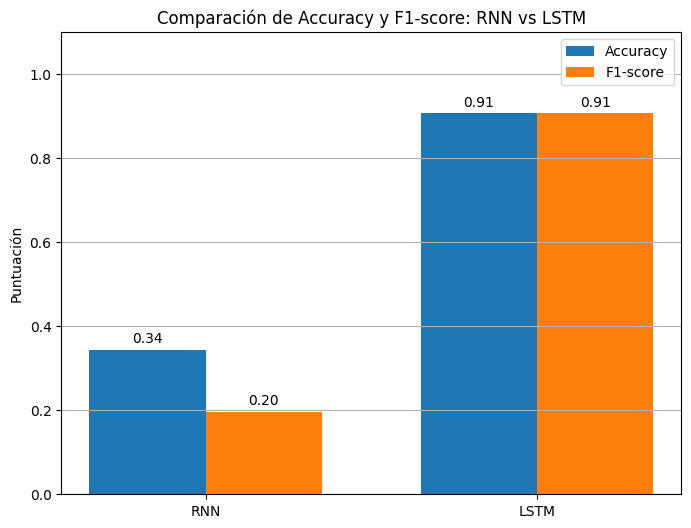

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Valores de métricas
models = ['RNN', 'LSTM']
accuracy = [0.3435, 0.9075]
f1_scores = [0.1962, 0.9068]

x = np.arange(len(models))  # Posiciones para los grupos
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-score')

# Etiquetas y títulos
ax.set_ylabel('Puntuación')
ax.set_title('Comparación de Accuracy y F1-score: RNN vs LSTM')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Mostrar valores encima de cada barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # Offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.1)  # Escalar un poquito más arriba para que no quede apretado
plt.grid(axis='y')
plt.show()


##Conclusiones


- El modelo RNN tradicional mostró limitaciones severas para la tarea de clasificación de emociones.  
  Con un accuracy final de 34.35% y un F1-score de 19.62%, el modelo fue incapaz de capturar adecuadamente las diferencias semánticas entre las clases emocionales, tendiendo a predecir mayoritariamente una única categoría.

- En contraste, el modelo LSTM logró un desempeño sobresaliente, alcanzando un accuracy de 90.75% y un F1-score de 90.68%.  
  Gracias a su arquitectura con mecanismos de memoria controlada (gates), el LSTM fue capaz de aprender dependencias de largo plazo, capturando de manera precisa las relaciones contextuales necesarias para una correcta clasificación emocional.

- El análisis de las matrices de confusión evidencia que mientras el RNN presenta confusión severa entre las clases, el LSTM muestra una diferenciación clara y balanceada entre todas las emociones.

- En tareas de procesamiento de lenguaje natural que requieren la modelación de secuencias complejas, como la clasificación de emociones, el uso de arquitecturas avanzadas como LSTM resulta altamente recomendable frente a modelos RNN tradicionales.
